# deconvolution with LSVR

In [35]:
import sys
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import glob
sys.path.append('../src')
from lsvr import run_multiprocess_deconvolution
from utils import load_cell_to_group, zhu_ref_data
import plotly.express as px

marker_genes_convert = load_cell_to_group()

In [36]:
from itertools import combinations, permutations
import random

def run_one_lsvr(target_df, timepoints, param_C=0.001, param_e=0.1, min_marker=0, min_markerscore=0.05):
    markers = pd.read_csv('../data/top_100_markers_postsub.csv', index_col=None, header=0)
    markers = markers[markers['marker_score'] > min_markerscore]

    bulk_protein_matrix = target_df[[x for x in target_df.columns if len(x) > 0]]
    bulk_protein_matrix = bulk_protein_matrix.T.reindex(set(markers['gene_id'])).T
    bulk_protein_matrix = bulk_protein_matrix.dropna(axis=1, how='all')

    marker_genes = {}
    exp_level = {}
    last_type = ''
    for i, row in markers.iterrows():
        if row['gene_id'] not in bulk_protein_matrix.columns:
            continue
            
        exp_level[row['gene_id']] = row['mean_expression']
        last_type = row['cell_group']
        if last_type in marker_genes.keys():
            marker_genes[last_type].extend([row['gene_id']])
        else:
            marker_genes[last_type] = [row['gene_id']]
    

    #markers['weighted_mean_expression'] = markers['marker_score'] * markers['mean_expression']
    # --- Marker genes and existing genes
    reference_df = markers.pivot_table(
            index=['gene_id'], # Use both gene IDs for better indexing
            columns='cell_group',
            values='mean_expression'
        )
    reference_df = reference_df.reindex(bulk_protein_matrix.columns.intersection(reference_df.index))
    reference_df[reference_df.isna()] = 0
    reference_df = reference_df.loc[:, (reference_df>0).sum(axis=0)>min_marker] #################### CUTOFF

    #  Run Deconvolution
    final_proportions_df = run_multiprocess_deconvolution(
        bulk_protein_matrix, 
        reference_df,
        max_workers=18 # Use all available cores
    )
    
    # Concatenate the results into a single DataFrame for final output
    final_df = pd.concat(final_proportions_df, axis=1).T
    final_df.index = bulk_protein_matrix.index
    
    final_df['timepoints'] = timepoints
    
    return final_df

In [140]:
PXD025128_df = load_LFQ_intensities_file('../data/PXD025128_bulk/LFQ_intensities.csv')
print(set(['_'.join(x.split('_')[0:2]) for x in PXD025128_df.columns]))
PXD025128_df = PXD025128_df[[x for x in PXD025128_df.columns if 'eat2_d' in x]]
PXD025128_df = PXD025128_df[[x for x in PXD025128_df.columns if 'MG132' not in x]]
PXD025128_df = PXD025128_df[PXD025128_df.index != 'NA']
PXD025128_df = PXD025128_df[~PXD025128_df.index.duplicated(keep='first')]
target_df = PXD025128_df.T
time_points = [int(x.split('_')[1].lstrip('d')) for x in target_df.index]

PXD025128_df

{'daf2_d15', 'daf2_d5', 'N2_d10', 'daf2_d1', 'eat2_d1', 'N2_d1', 'daf2_d10', 'N2_d15', 'WormBase', 'eat2_d5', 'eat2_d15', 'N2_d5', 'eat2_d10'}


,eat2_d1_1,eat2_d1_2,eat2_d1_3,eat2_d1_4,eat2_d10_1,eat2_d10_2,eat2_d10_3,eat2_d10_4,eat2_d15_1,eat2_d15_2,...,eat2_d15_DMSO_3,eat2_d15_DMSO_4,eat2_d5_1,eat2_d5_2,eat2_d5_3,eat2_d5_4,eat2_d5_DSMO_1,eat2_d5_DSMO_2,eat2_d5_DSMO_3,eat2_d5_DSMO_4
,11.108637,11.710837,11.335296,12.040676,14.261175,13.001355,11.939428,12.864736,14.900580,14.956862,...,15.232180,15.347281,12.405048,12.252639,11.928534,12.114084,11.902763,12.307791,11.923753,11.378017
WBGene00000004,12.904300,13.325636,12.906490,13.146628,14.850739,12.543784,14.704380,14.936715,14.062539,15.254755,...,15.659267,15.596169,13.290058,13.485389,12.991374,13.066947,13.660183,13.662845,13.855882,12.684171
WBGene00000010,13.783136,13.915107,13.850321,13.151668,14.485708,15.181456,16.181818,15.086154,18.878869,17.383939,...,17.179873,15.743009,14.392066,14.534277,14.405299,14.442800,14.181241,14.734536,13.885560,12.120371
WBGene00000022,11.354687,11.072763,11.153638,10.609524,11.885054,12.977048,12.665049,13.436487,13.565598,15.094459,...,14.969984,15.433192,13.020055,13.227778,12.808872,13.247257,12.881753,12.354374,13.273015,13.145492
WBGene00000040,17.896501,18.665197,18.397689,18.530633,17.986507,17.771719,18.339139,18.301434,18.376554,18.553159,...,19.812835,21.735195,18.518389,18.601786,18.416424,18.471693,17.460178,18.052228,18.234213,17.568631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00195239,13.678938,13.536575,13.215127,12.702031,12.886972,13.605434,13.769852,13.026984,13.814294,15.431791,...,13.985745,15.795562,12.048892,12.196116,10.831430,13.244576,10.801961,10.758020,11.899434,14.551352
WBGene00202498,10.085420,10.886517,14.193269,11.629104,13.706068,13.384483,12.261975,13.483719,14.394232,15.443751,...,15.231240,13.668874,11.309685,11.450066,12.066428,12.540843,11.205565,12.261103,11.521831,12.070466
WBGene00219423,11.347976,11.377755,10.559412,12.463717,12.692567,13.677351,12.230812,12.074023,13.453317,15.300398,...,15.497415,14.853274,13.753603,12.473748,13.397972,13.107734,11.978440,11.097804,11.056876,12.204365
WBGene00235093,6.875344,10.525998,11.580553,11.334665,16.543325,16.551179,15.389730,15.671656,17.091072,18.888405,...,15.153591,15.895167,11.892158,12.174064,12.118926,12.164061,12.093797,12.006666,13.228879,12.435264


In [141]:
final_df = run_one_lsvr(PXD025128_df.T.apply(lambda x: 2**x), time_points, param_C=0.001, param_e=0.01,  min_marker=0, min_markerscore=0.05)
final_df.to_csv('Bulk_N2_proportion_cutoff50.csv')

Deconvoluting Samples: 100%|█████████████████████████████████| 24/24 [00:01<00:00, 23.27it/s]


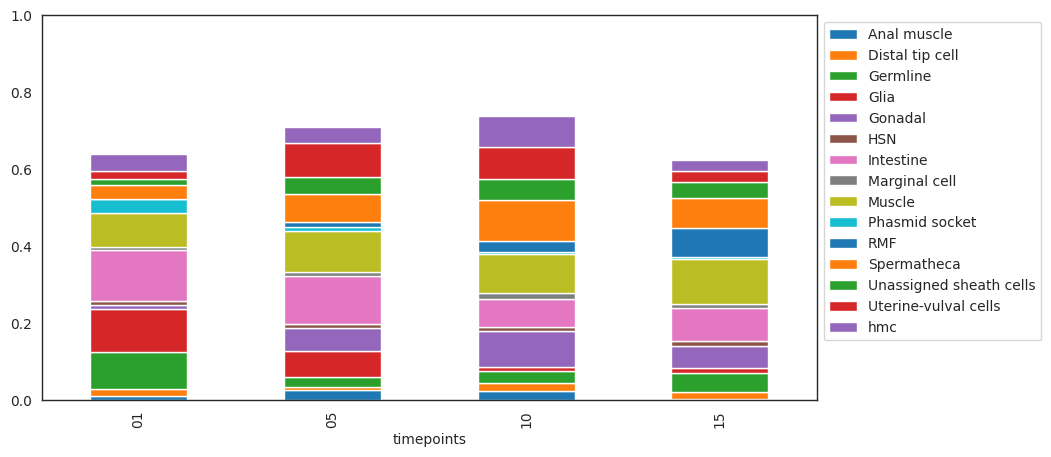

In [142]:
final_df = pd.read_csv('Bulk_N2_proportion_cutoff50.csv', index_col=0, header=0)

# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T

final_df['timepoints'] = [f"{str(x).zfill(2)}" for x in time_points]

target_columns = final_df.columns[:-1]
target_columns = final_df.groupby('timepoints').mean().mean().index[final_df.groupby('timepoints').mean().mean() > 0.01]

g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(10,5))
#g = mean_df.groupby('timepoints').mean().plot(kind='bar', stacked=True, figsize=(10,5))
#g.legend([])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))

final_df.groupby('timepoints').mean().T.to_csv('tin_proportions.csv')
final_tin_df = final_df

# Single-worm Proteomics by Zhu et  al

In [37]:
target_df, time_points = zhu_ref_data()
target_df = target_df.loc[:,~target_df.isnull().values.all(axis=0)]
target_df = target_df.astype(np.float32)
#time_points = [int(x.split('_')[1]) for x in target_df.index]

final_df = run_one_lsvr(target_df, time_points, param_C=0.01, param_e=0.1,  min_marker=5, min_markerscore=0.08)
final_df.to_csv('../results/Zhu_N2_proportion.csv')

/home/youngjunpark/Git/deconvolution_C_elegans/notebooks/../src/utils.py:23: DtypeWarning:

Columns (830,831) have mixed types. Specify dtype option on import or set low_memory=False.

Deconvoluting Samples: 100%|██████████████████████████████| 101/101 [00:00<00:00, 1166.42it/s]


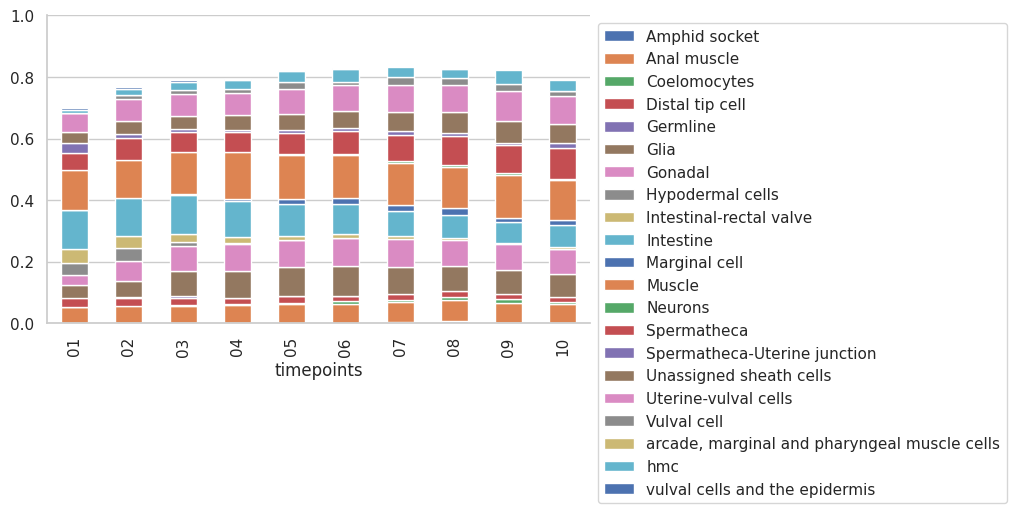

In [40]:
final_df = pd.read_csv('../results/Zhu_N2_proportion.csv', index_col=0, header=0)

# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T

final_df['timepoints'] = [(x.split('_')[-2].split(' ')[-1]).lstrip('D').zfill(2) for x in final_df.index]

target_columns = final_df.columns[:-1]
target_columns = final_df.groupby('timepoints').mean().mean().index[final_df.groupby('timepoints').mean().mean() > 0.0]

g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(7,4))
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='x')

final_df.groupby('timepoints').mean().T.to_csv('../results/Zhu_plot_data.csv')
plt.savefig('../results/Zhu_proportion.svg')

    timepoints                           group     value
0           01                   Amphid socket  0.002653
1           02                   Amphid socket  0.000000
2           03                   Amphid socket  0.000031
3           04                   Amphid socket  0.001462
4           05                   Amphid socket  0.002751
..         ...                             ...       ...
205         06  vulval cells and the epidermis  0.003684
206         07  vulval cells and the epidermis  0.000000
207         08  vulval cells and the epidermis  0.000979
208         09  vulval cells and the epidermis  0.000000
209         10  vulval cells and the epidermis  0.000000

[210 rows x 3 columns]


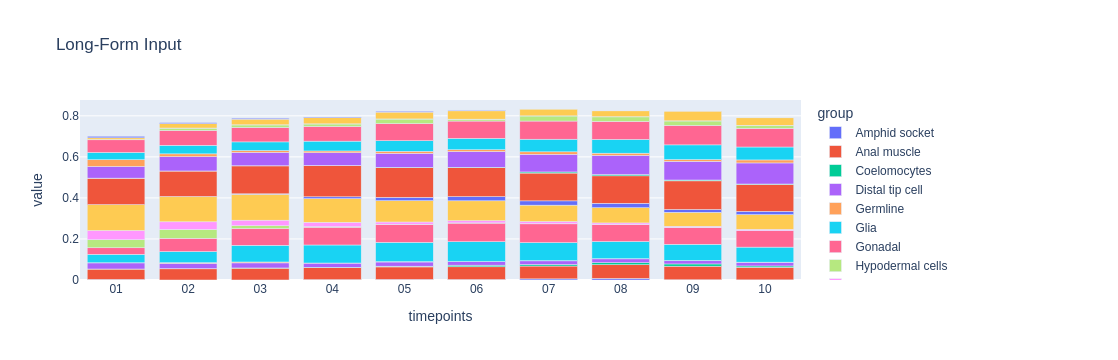

In [41]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
print(long_df)
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [61]:
# correlation of samples from same days
final_df = pd.read_csv('../results/Zhu_N2_proportion.csv', index_col=0, header=0)

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.9080596369267029
day 2: 	 0.9002793440759831
day 3: 	 0.9009656741569816
day 4: 	 0.9049743421382207
day 5: 	 0.9017452997308603
day 6: 	 0.9127438083461674
day 7: 	 0.9238065071084114
day 8: 	 0.8993782121820018
day 9: 	 0.9226483077001404
day 10: 	 0.8974837972004789


0it [00:00, ?it/s]

Random pair correlation: 	0.7918643497581013


/tmp/ipykernel_757386/1030315332.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




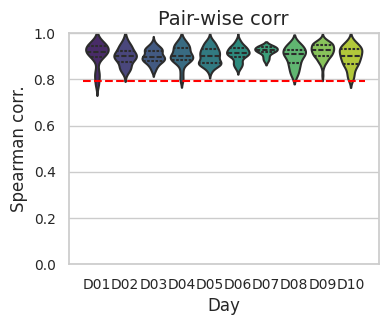

In [63]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10',]
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=9.5, colors='red', linestyles='--')
plt.ylim((0,1))
plt.savefig('../results/Zhu_corr.svg')
plt.show()

# swRNAseq N2

In [28]:
swRNAseq_df = pd.read_hdf('../data/swRNAseq/swRNAseq_N2_norm.h5', index_col=0, header=0)
swRNAseq_df = swRNAseq_df.loc[:, np.sum(swRNAseq_df>0, axis=0) > 10000]
swRNAseq_df = swRNAseq_df.div(np.sum(swRNAseq_df,axis=0), axis=1) *1e5
timepoints2 = [int(x.split('_')[1]) for x in swRNAseq_df.columns]
swRNAseq_df = swRNAseq_df.T
swRNAseq_df

,WBGene00000001,WBGene00000002,WBGene00000003,WBGene00000004,WBGene00000005,WBGene00000006,WBGene00000007,WBGene00000008,WBGene00000009,WBGene00000010,...,WBGene00306004,WBGene00306005,WBGene00306012,WBGene00306013,WBGene00306014,WBGene00306070,WBGene00306076,WBGene00306080,WBGene00306081,WBGene00306121
N2_10_QZ0_20.Rep_1,2.774802,0.904892,0.689876,0.855877,0.786533,0.117378,0.254378,0.664307,0.691281,1.873432,...,0.422561,0.000000,1.387676,10.392236,2.864649,9.975365,0.000000,0.358160,0.269117,0.580957
N2_10_QZ0_20.Rep_10,3.808191,0.249879,0.875119,2.140557,0.000000,0.372149,0.427132,0.343530,0.394492,2.291008,...,0.146231,0.618454,0.188927,8.215322,0.000000,0.000000,0.000000,0.239510,0.095065,0.367434
N2_10_QZ0_20.Rep_11,5.746129,0.141667,0.407543,0.773874,0.085103,0.000000,0.139414,0.058426,0.079588,2.689932,...,0.165563,0.000000,0.427865,7.247283,0.972538,5.712582,0.000000,0.812670,0.000000,0.130820
N2_10_QZ0_20.Rep_12,3.827738,0.131473,0.745478,1.001076,0.252681,0.363313,0.099954,0.096449,0.098550,1.799788,...,0.000000,0.000000,0.543986,5.228450,2.630595,3.175490,0.000000,0.347191,0.000000,0.194466
N2_10_QZ0_20.Rep_13,4.696136,0.302655,0.454266,0.701370,0.096944,0.152373,0.172591,0.000000,0.056721,2.568437,...,0.000000,0.523868,0.942854,2.861591,0.000000,3.667869,0.000000,0.401818,0.000000,0.083164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N2_8_QZ0_20.Rep_974,3.319885,0.285095,0.618089,0.755103,0.000000,0.160480,0.270632,0.156734,0.600202,0.859840,...,0.440384,0.461524,1.702101,9.752090,0.000000,9.407262,0.460193,0.358755,0.143793,0.471919
N2_8_QZ0_20.Rep_975,3.972851,0.183515,0.642704,1.389745,0.176353,0.213112,0.235433,0.075726,0.283710,2.207623,...,0.109384,0.236549,0.142300,1.727426,0.697507,3.334834,0.114496,8.178717,0.211579,0.134116
N2_8_QZ0_20.Rep_976,4.284447,0.331517,0.539054,1.111196,0.000000,0.000000,0.803905,0.501837,0.466205,1.895240,...,0.201312,0.000000,0.527400,10.408002,4.059076,0.000000,0.210931,0.339163,1.930624,0.334548
N2_8_QZ0_20.Rep_977,3.896854,0.183952,0.713264,0.502362,0.000000,0.423699,0.525520,0.050679,0.051801,0.753497,...,0.230854,0.254735,6.375530,122.747879,12.879270,1.561916,0.000000,0.000000,0.072913,0.590696


In [30]:
final_df = run_one_lsvr(swRNAseq_df, timepoints2, param_C=0.001, param_e=0.01,  min_marker=0, min_markerscore=0.08)
final_df.to_csv('../results/swRNAseq_N2_proportion.csv')

Deconvoluting Samples: 100%|██████████████████████████████| 1836/1836 [01:24<00:00, 21.74it/s]


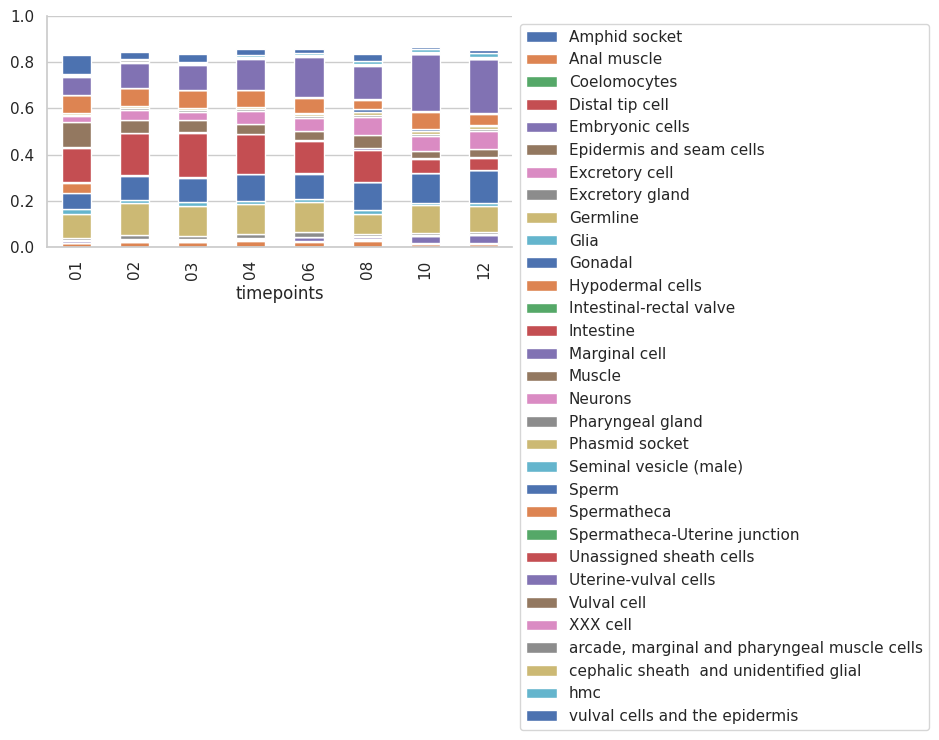

In [32]:
final_df = pd.read_csv('../results/swRNAseq_N2_proportion.csv', index_col=0, header=0)

# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T


final_df['timepoints'] = [(x.split('_')[1]).zfill(2) for x in final_df.index]

target_columns = final_df.groupby('timepoints').mean().mean().index[final_df.groupby('timepoints').mean().mean() > 0.00]

g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(6,3))
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='x')
plt.savefig('../results/swRNA_N2_proportion.svg')

final_df.groupby('timepoints').mean().T.to_csv('../results/swRNA_N2_plot_data.csv')
swRNAseq_N2_df = final_df

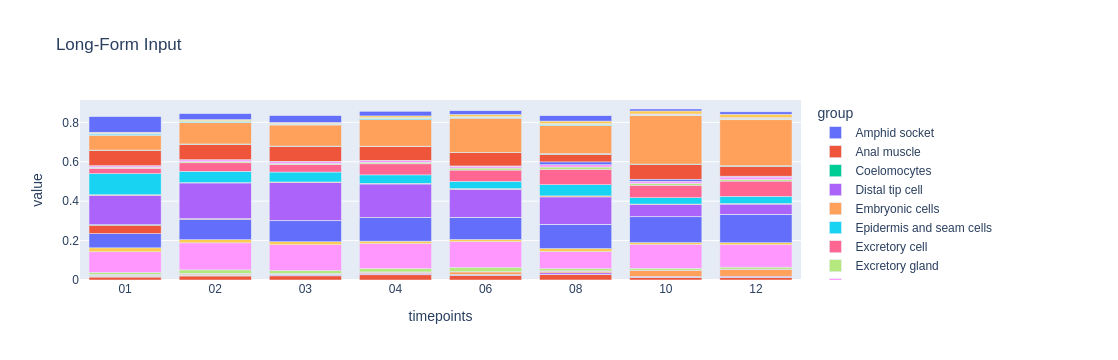

In [34]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [58]:
# correlation of samples from same days
final_df = pd.read_csv('../results/swRNAseq_N2_proportion.csv', index_col=0, header=0)

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.8281017185901773
day 2: 	 0.8660553716234785
day 3: 	 0.8271647432376161
day 4: 	 0.8792678106645536
day 6: 	 0.8629753451501262
day 8: 	 0.8181592818593316
day 10: 	 0.7534814753235805
day 12: 	 0.766567453861903


0it [00:00, ?it/s]

Random pair correlation: 	0.6708095347079185


/tmp/ipykernel_757386/686674845.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




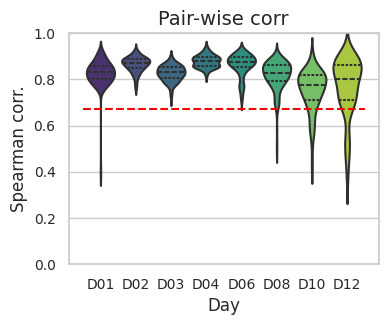

In [60]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['D01', 'D02', 'D03', 'D04', 'D06', 'D08', 'D10', 'D12']
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=7.5, colors='red', linestyles='--')
plt.ylim((0,1))
plt.savefig('../results/swRNAseq_N2_corr.svg')
plt.show()

# swRNAseq glp-1

In [47]:
swRNAseq_df = pd.read_hdf('../data/swRNAseq/swRNAseq_glp1_norm.h5', index_col=0, header=0)
swRNAseq_df = swRNAseq_df.loc[:, np.sum(swRNAseq_df>0, axis=0) > 10000]
swRNAseq_df = swRNAseq_df.div(np.sum(swRNAseq_df,axis=0), axis=1) *1e5

timepoints2 = [int(x.split('_')[3]) for x in swRNAseq_df.columns]
swRNAseq_df = swRNAseq_df.T

In [48]:
final_df = run_one_lsvr(swRNAseq_df, timepoints2, param_C=0.001, param_e=0.01,  min_marker=0, min_markerscore=0.08)
final_df.to_csv('../results/swRNAseq_glp1_proportion.csv')

Deconvoluting Samples: 100%|████████████████████████████████| 175/175 [00:06<00:00, 26.54it/s]


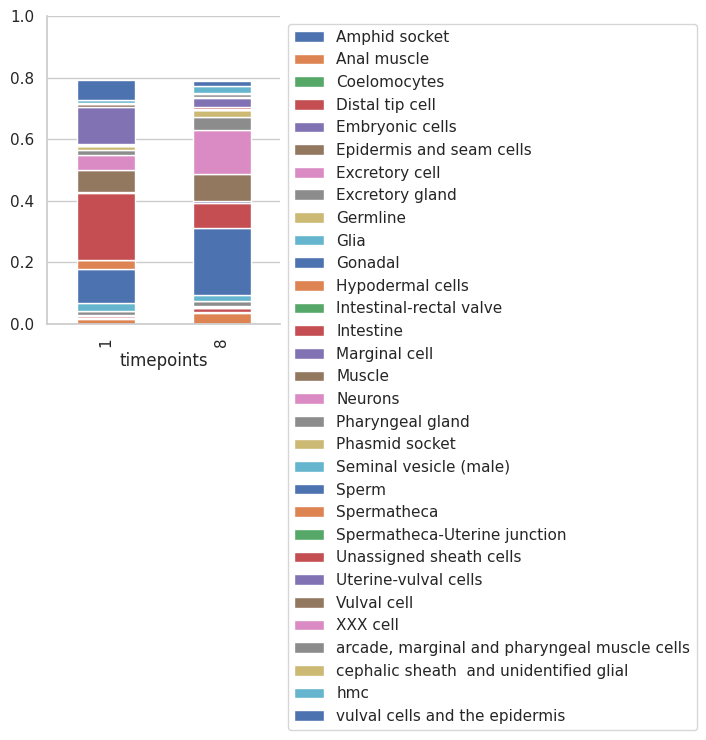

In [49]:
final_df = pd.read_csv('../results/swRNAseq_glp1_proportion.csv', index_col=0, header=0)


# Aggregate
final_df = final_df.T
final_df['group'] = final_df.index
final_df['group'] = final_df['group'].map(marker_genes_convert)
final_df['group'] = [x.split(' is ')[0].split(' are ')[0] if type(x) is str and "These gene" not in x else x for x in final_df['group']]
final_df = final_df.groupby('group').agg('sum')
final_df = final_df.T

final_df['timepoints'] = timepoints2

target_columns = final_df.columns[:-1]

g = final_df.groupby('timepoints').mean()[target_columns].plot(kind='bar', stacked=True, figsize=(3,4))
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
g.axes.set_ylim((0,1))
g.axes.spines['top'].set_visible(False)
g.axes.spines['right'].set_visible(False)
g.axes.get_xaxis().set_visible(True)
plt.grid(axis='x')
plt.savefig('../results/swRNA_glp-1_proportion.svg')

final_df.groupby('timepoints').mean().T.to_csv('../results/swRNAseq_glp1_plot_data.csv')

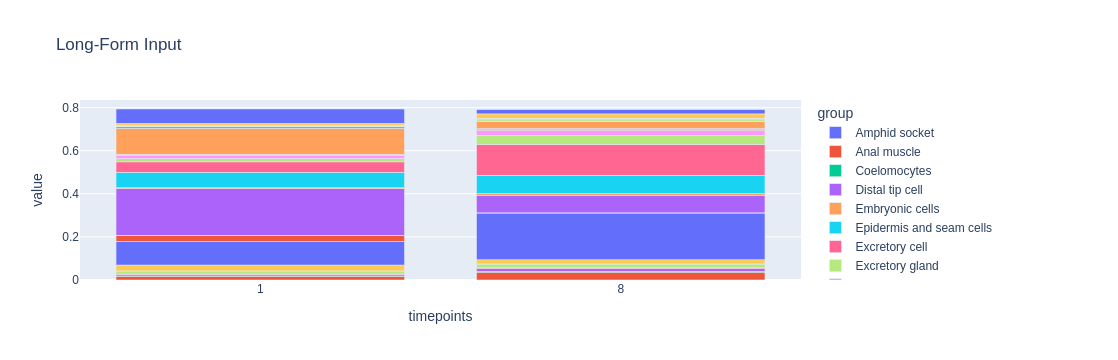

In [50]:
long_df = final_df.groupby('timepoints').mean()[target_columns].reset_index().melt(id_vars='timepoints')
fig = px.bar(long_df, x="timepoints", y="value", color="group", title="Long-Form Input")
fig.show()

In [51]:
# correlation of samples from same days
final_df = pd.read_csv('../results/swRNAseq_glp1_proportion.csv', index_col=0, header=0)

for_plot=[]
for timepoint, _x in final_df.groupby('timepoints'):
    results = []
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break
            
    for_plot.append(results)
    print(f"day {timepoint}: \t {np.mean(results)}")

# Random pair correlation

results=[]
for _i, _j in tqdm(permutations(range(len(final_df)), 2)):
    corr_x = final_df.values[_i, :-1]        
    corr_y = final_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
print(f"Random pair correlation: \t{np.mean(results)}")

day 1: 	 0.8321257316074145
day 8: 	 0.8291548397502075


0it [00:00, ?it/s]

Random pair correlation: 	0.7100293530772974


/tmp/ipykernel_757386/409679396.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




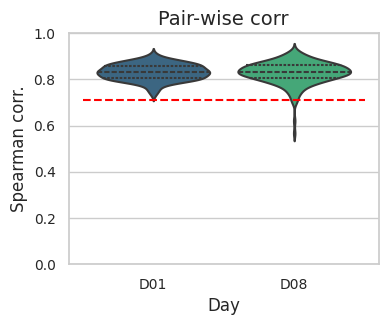

In [57]:
to_melt = pd.DataFrame(for_plot).T
to_melt.columns = ['D01', 'D08', ]
df_long = to_melt.melt()

# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Pair-wise corr', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Spearman corr.', fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.hlines(y=np.mean(results), xmin=-0.5, xmax=1.5, colors='red', linestyles='--')
plt.ylim((0,1))
plt.savefig('../results/swRNAseq_glp1_corr.svg')
plt.show()

In [111]:

swRNAseq_df = pd.read_hdf('../notebooks/swRNAseq/swRNAseq_N2_norm.h5', index_col=0, header=0)
swRNAseq_df = swRNAseq_df.loc[:, np.sum(swRNAseq_df>0, axis=0) > 10000]
swRNAseq_df = swRNAseq_df.div(np.sum(swRNAseq_df,axis=0), axis=1) *1e5
timepoints2 = [int(x.split('_')[1]) for x in swRNAseq_df.columns]
#timepoints2 = [int(x.split('_')[3]) for x in swRNAseq_df.columns]

swRNAseq_df = swRNAseq_df.T

grid_search_df = run_one_lsvr(swRNAseq_df, timepoints2, param_C=0.001, param_e=0.01,  min_marker=0, min_markerscore=0.08)
#col = grid_search_df.mean(axis=0)[grid_search_df.mean(axis=0)>0.001].index
k = []
for timepoint, _x in grid_search_df.groupby('timepoints'):
    results = []
    print(_x.shape)
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break

    print(len(results))
    k.append(results)
    print(timepoint, np.mean(results))

Deconvoluting Samples: 100%|█████████████████████████████| 1836/1836 [01:21<00:00, 22.49it/s]


(648, 32)
200
1 0.9335121920712808
(100, 32)
200
2 0.9290356546828107
(84, 32)
200
3 0.9442426166899878
(94, 32)
200
4 0.9702692333814276
(91, 32)
200
6 0.9394281990930062
(647, 32)
200
8 0.8778148806753494
(88, 32)
200
10 0.8994638025946453
(84, 32)
200
12 0.8989749987574891


In [123]:
results=[]
for _i, _j in tqdm(permutations(range(len(grid_search_df)), 2)):
    corr_x = grid_search_df.values[_i, :-1]        
    corr_y = grid_search_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
np.mean(results)

99999it [01:04, 1548.39it/s]


np.float64(0.7777621212405312)

In [122]:
np.mean(results)

np.float64(0.778121199570798)

    variable     value
0        D01  0.954232
1        D01  0.967487
2        D01  0.894137
3        D01  0.942113
4        D01  0.973198
..       ...       ...
395      D08  0.972689
396      D08  0.887786
397      D08  0.937990
398      D08  0.850370
399      D08  0.972164

[400 rows x 2 columns]


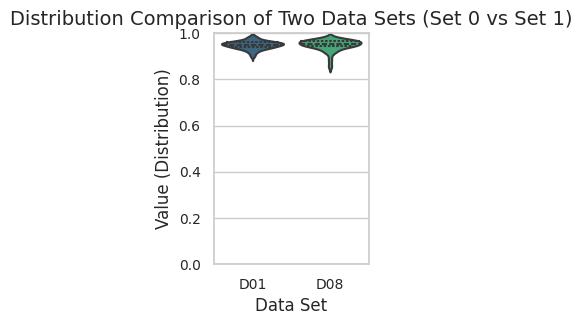

In [98]:
t = pd.DataFrame(k).T
#t.columns = ['D01', 'D02', 'D03', 'D04', 'D06', 'D08', 'D10', 'D12', ]
t.columns = ['D01', 'D08', ]
df_long = t.melt(
    #id_vars=['Set'], 
    #value_vars=t.columns, 
    #var_name='Metric', 
    #value_name='Value'
)
print(df_long)
# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

# 3. Create the violin plot
# Set a nice style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(2, 3))

# Generate the violin plot using the 'Set' for the X-axis (category) 
# and 'Value' for the Y-axis (distribution)
sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Distribution Comparison of Two Data Sets (Set 0 vs Set 1)', fontsize=14)
plt.xlabel('Data Set', fontsize=12)
plt.ylabel('Value (Distribution)', fontsize=12)

# Enhance tick labels
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.ylim((0,1))
# Display the plot
plt.savefig('swRNA_day_corr.svg')
plt.show()



In [124]:
agg_df = dl.processed_data_load("../data/aggregated_data/202510_agg_data.h5", "51e4a576eead0c18470d52ed45172862")
target_df = agg_df[agg_df['study'] == 'PXD039330_byZhu']
target_df = target_df.loc[:,~target_df.isnull().values.all(axis=0)]
target_df = target_df.iloc[:,:-5]
#target_df = target_df.T.reindex(set(ribosomal[0])).T
target_df = target_df.astype(np.float32)
time_points = [int(x.split(' ')[-1].split('_')[0].lstrip('D')) for x in target_df.index]
set(time_points)
#target_df = target_df.T

grid_search_df = run_one_lsvr(target_df, time_points, param_C=0.01, param_e=0.1,  min_marker=5, min_markerscore=0.08)
print(grid_search_df)
#col = grid_search_df.mean(axis=0)[grid_search_df.mean(axis=0)>0.001].index
k = []
for timepoint, _x in grid_search_df.groupby('timepoints'):
    results = []
    print(_x.shape)
    for _i, _j in (permutations(range(len(_x)), 2)):
        corr_x = _x.values[_i, :]        
        corr_y = _x.values[_j, :]
        
        corr_res = stats.spearmanr(list(corr_x), list(corr_y))
        results.append(corr_res[0])
        if len(results) >= 200:
            break

    print(len(results))
    k.append(results)
    print(timepoint, np.mean(results))

Deconvoluting Samples: 100%|█████████████████████████████| 101/101 [00:00<00:00, 1248.84it/s]


group                Amphid socket  Anal muscle  Coelomocytes  \
LFQ intensity D1_1        0.000000     0.048572      0.000000   
LFQ intensity D1_10       0.000000     0.047950      0.000000   
LFQ intensity D1_11       0.000218     0.050955      0.000000   
LFQ intensity D1_2        0.000000     0.051020      0.000000   
LFQ intensity D1_3        0.000000     0.047104      0.000000   
...                            ...          ...           ...   
LFQ intensity D9_5        0.000679     0.063801      0.013884   
LFQ intensity D9_6        0.007781     0.066724      0.012224   
LFQ intensity D9_7        0.000000     0.060501      0.012672   
LFQ intensity D9_8        0.002573     0.070242      0.012249   
LFQ intensity D9_9        0.000000     0.067486      0.012746   

group                Distal tip cell  Embryonic cells  Germline      Glia  \
LFQ intensity D1_1          0.033353              0.0       0.0  0.052978   
LFQ intensity D1_10         0.021480              0.0       0.0  

     variable     value
0         D01  0.980334
1         D01  0.951335
2         D01  0.964028
3         D01  0.956468
4         D01  0.953749
...       ...       ...
1315      D10       NaN
1316      D10       NaN
1317      D10       NaN
1318      D10       NaN
1319      D10       NaN

[1320 rows x 2 columns]


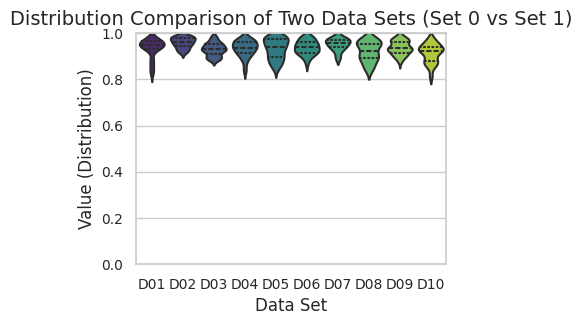

In [110]:
t = pd.DataFrame(k).T
t.columns = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07','D08', 'D09', 'D10', ]
df_long = t.melt(
    #id_vars=['Set'], 
    #value_vars=t.columns, 
    #var_name='Metric', 
    #value_name='Value'
)
print(df_long)
# Convert 'Set' to string for categorical plotting
df_long['variable'] = df_long['variable'].astype(str)

# 3. Create the violin plot
# Set a nice style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4, 3))

# Generate the violin plot using the 'Set' for the X-axis (category) 
# and 'Value' for the Y-axis (distribution)
sns.violinplot(
    x='variable', 
    y='value', 
    data=df_long, 
    palette='viridis', 
    inner='quartile',  # Shows quartiles (median, Q1, Q3) inside the violin
    linewidth=1.5
)

# Add plot titles and labels for clarity
plt.title('Distribution Comparison of Two Data Sets (Set 0 vs Set 1)', fontsize=14)
plt.xlabel('Data Set', fontsize=12)
plt.ylabel('Value (Distribution)', fontsize=12)

# Enhance tick labels
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.ylim((0,1))
# Display the plot
plt.savefig('swRNA_day_corr.svg')
plt.show()



In [125]:
results=[]
for _i, _j in tqdm(permutations(range(len(grid_search_df)), 2)):
    corr_x = grid_search_df.values[_i, :-1]        
    corr_y = grid_search_df.values[_j, :-1]
    
    corr_res = stats.spearmanr(list(corr_x), list(corr_y))
    results.append(corr_res[0])
    if len(results) >= 100000:
        break
np.mean(results)

10100it [00:05, 1718.63it/s]


np.float64(0.8566963318316904)